In [1]:
# v0.1 Contributed by Shuhong Huang ...
%matplotlib inline

In [2]:
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, ward, single
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics.pairwise import pairwise_distances
from sklearn_extra.cluster import KMedoids

In [3]:
# load your data

import scipy.io as sio
ls_data = sio.loadmat('fish1')['allfingprints'][0][0][0][0][0][1:600000:1000]

from bouter import EmbeddedExperiment
from bouter import utilities

behavior = EmbeddedExperiment(r'./v3/210316_f6')
theta = utilities.predictive_tail_fill(behavior.behavior_log.loc[:, behavior.tail_columns].values)
tail_sum = theta[:,-1]+theta[:,-2]-theta[:,0]-theta[:,1]
bout_list = behavior.get_bouts(tail_sum)
max_bout_length = np.max(bout_list[:,1]-bout_list[:,0])
bout_data = np.zeros((bout_list.shape[0],max_bout_length))
for idx,cur_bout in enumerate(bout_list):
    bout_data[idx][:cur_bout[1]-cur_bout[0]] = tail_sum[cur_bout[0]:cur_bout[1]]

data shape: (406, 101)
nan value existing: False


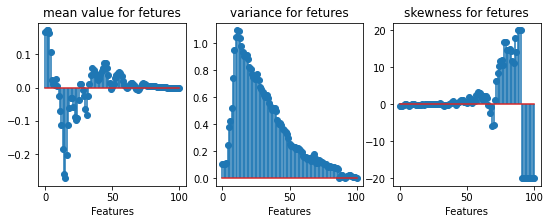

PCA-embedded data acquired
TSNE-embedded data acquired
dwt data acquired


In [4]:
# Step 0: prepossing the data 

data = bout_data

# Check basic property of your data

print("data shape: {}".format(data.shape))
print("nan value existing: {}".format(np.isnan(np.sum(data))))
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(9, 3))
ax1.stem(np.mean(data,axis=0))
ax1.set_title('mean value for fetures')
ax1.set(xlabel='Features')
ax2.set_title('variance for fetures')
ax2.stem(np.std(data,axis=0))
ax2.set(xlabel='Features')
ax3.set_title('skewness for fetures')
ax3.stem(stats.skew(data,axis=0))
ax3.set(xlabel='Features')
plt.subplots_adjust(wspace =0.2, hspace =0)
plt.show()

# Normalize your data (if features follow Gaussian)
do_normalization = False
nor_data = None
if do_normalization:
    nor_data = stats.zscore(data)
    print('Normalized data acquired')
    
# Log your data (if fetures follow power law)
do_log = False
log_data = None
if do_log:
    log_data = MinMaxScaler((0,10)).fit(data).transform(data)
    print('Log data acquired')

# Get PCA embedding of your data (for high-dimensional data)
do_pca = True
num_of_pca = 10
pca_data = None
if do_pca:
    pca_data = PCA(n_components=num_of_pca).fit(data).transform(data)
    print('PCA-embedded data acquired')

# Get TSNE embedding of your data (for high-dimensional data)
do_tsne = True
num_of_d = 3
tsne_data = None
if do_tsne:
    tsne_data = TSNE(n_components=num_of_d).fit_transform(data)
    print('TSNE-embedded data acquired')


# Get DWT embedding of your data (only for time series)
do_dwt = True
wavelet = 'db3'
dwt_data = None
if do_dwt:
    import pywt
    dwt_data = pywt.dwt(data,wavelet)[0]
    print('dwt data acquired')

# Get AutoEncoder embedding of your data (pytorch required, for high-dimensional data)
do_autoencoder = False
ae_data = None
if do_autoencoder:
    import torch
    from torch import nn, optim
    from torch.autograd import Variable
    from torchvision import transforms, datasets
    class autoencoder(nn.Module):
        def __init__(self):
            super(autoencoder, self).__init__()
            self.encoder = nn.Sequential(nn.Linear(data.shape[1], 128),
                                         nn.ReLU(),
                                         nn.Linear(128, 64),
                                         nn.ReLU(),
                                         nn.Linear(64, 32),
                                         nn.ReLU(),
                                         nn.Linear(32, 10))
            self.decoder = nn.Sequential(nn.Linear(10, 32),
                                         nn.ReLU(),
                                         nn.Linear(32, 64),
                                         nn.ReLU(),
                                         nn.Linear(64, 128),
                                         nn.ReLU(),
                                         nn.Linear(128, data.shape[1]),
                                         nn.Tanh())
        def forward(self, x):
            encode = self.encoder(x)
            decode = self.decoder(encode)
            return encode, decode
        
    lr = 1e-2
    weight_decay = 1e-5
    epoches = 4000
    model = autoencoder()
    
    train_data = torch.from_numpy(data).float()
    criterion = nn.MSELoss()
    optimizier = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    if torch.cuda.is_available():
        model.cuda()
        train_data = train_data.cuda()
    for epoch in range(epoches):
        if epoch in [epoches * 0.25, epoches * 0.5]:
            for param_group in optimizier.param_groups:
                param_group['lr'] *= 0.1
        # forward
        encode, decode = model(train_data)
        loss = criterion(decode, train_data)
        # backward
        optimizier.zero_grad()
        loss.backward()
        optimizier.step()
    print("epoch: {}, loss is {}".format((epoch+1), loss.data))
    ae_data, _ = model(train_data)
    ae_data = ae_data.cpu().detach().numpy()
    prediction = _.cpu().detach().numpy()
    
    # check AutoEncoder performance
    fig, ax = plt.subplots(3, 3, figsize=(9, 9))
    fig.suptitle('random 9 examples to show fitness of ae')
    
    idx_list = np.random.randint(0,data.shape[1],9)
    for ax_,idx in zip(ax.flat,idx_list):
        ax_.plot(data[idx])
        ax_.plot(prediction[idx])
        ax_.label_outer()
    print('autocoder-embedded data acquired')

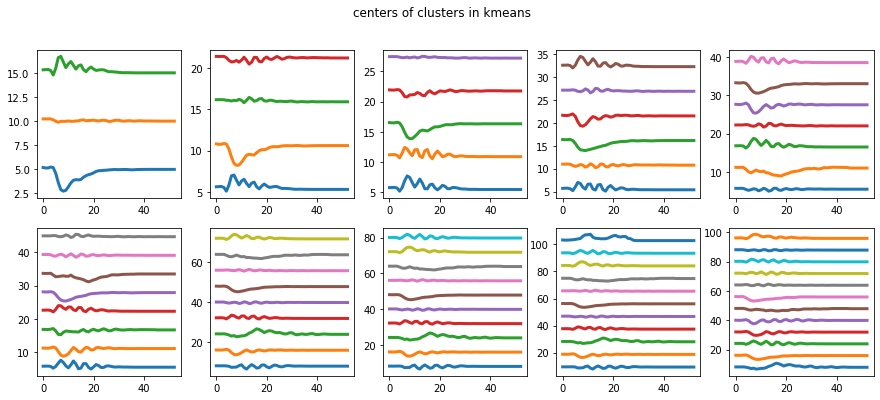

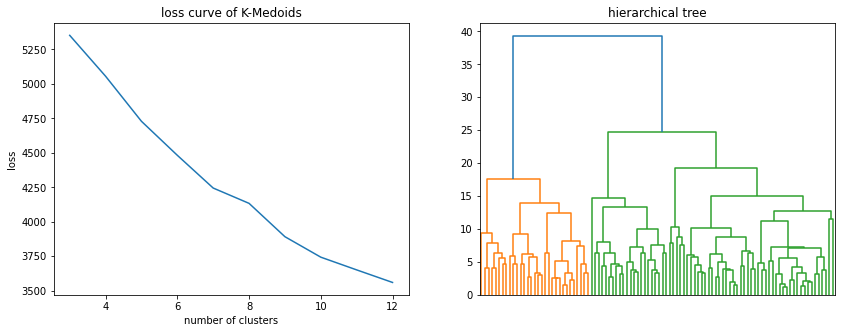

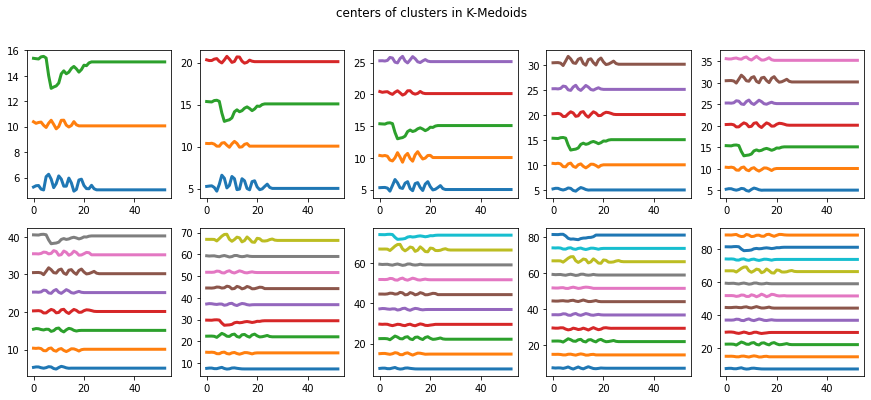

k-means clusters acquired
K-Medoids clusters acquired
hierachical clusters acquired


In [5]:
# step 1: k-means and hierarchical clustering

# classical k-means method
# the proper k shoule be the turning point in the loss curve
# or should have different centers

step1_data = dwt_data

k_min = 3
k_max = 12
num_of_trail = k_max-k_min+1

# k-means
fig, ax = plt.subplots(ceil(num_of_trail/5),5, figsize=(15, 3*ceil(num_of_trail/5)))
fig.suptitle('centers of clusters in kmeans')
loss = np.empty(num_of_trail)
for idx,k,ax_ in zip(range(num_of_trail),range(k_min,k_max+1),ax.flat[:num_of_trail]):
    k_means = KMeans(n_clusters=k, random_state=0).fit(step1_data)
    gap = 2*np.max(np.max(k_means.cluster_centers_,axis=1)-np.min(k_means.cluster_centers_,axis=1))
    loss[idx] = k_means.inertia_
    c = 0
    for i in k_means.cluster_centers_:
        c = c+1
        ax_.scatter(range(step1_data.shape[1]),i+c*gap,label=str(i),s=3)
plt.show()

# K-Medoids
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(range(k_min,k_max+1),loss)
ax[0].set(xlabel='number of clusters',ylabel='loss')
ax[0].set_title('loss curve of K-Medoids')

# show hierarchical tree
large_data = True
if large_data:
    # get 100 samples using K-means and see the tree 
    # (almost the same but cannot reveal the population of each cluster)
    k_means = KMeans(n_clusters=100, random_state=0).fit(step1_data)
    hier_data = k_means.cluster_centers_
    linkage_matrix = ward(hier_data)
    dendrogram(linkage_matrix,ax=ax[1])
    ax[1].set_title('hierarchical tree')
    plt.xticks([])
    plt.show()
else:
    linkage_matrix = ward(step1_data)
    dendrogram(linkage_matrix,ax=ax[1])
    ax[1].set_title('hierarchical tree')
    plt.xticks([])
    plt.show()

fig, ax = plt.subplots(ceil(num_of_trail/5),5, figsize=(15, 3*ceil(num_of_trail/5)))
fig.suptitle('centers of clusters in K-Medoids')
loss = np.empty(num_of_trail)
for idx,k,ax_ in zip(range(num_of_trail),range(k_min,k_max+1),ax.flat[:num_of_trail]):
    k_means = KMedoids(n_clusters=k, random_state=0).fit(step1_data)
    gap = 2*np.max(np.max(k_means.cluster_centers_,axis=1)-np.min(k_means.cluster_centers_,axis=1))
    loss[idx] = k_means.inertia_
    c = 0
    for i in k_means.cluster_centers_:
        c = c+1
        ax_.scatter(range(step1_data.shape[1]),i+c*gap,label=str(i),s=3)
plt.show()

# Finally, decide your number of clusters
number_of_cluster = 6
cluster_kmeans = KMeans(n_clusters=number_of_cluster, random_state=0).fit(step1_data).labels_
print('k-means clusters acquired')
cluster_kmedoids = KMedoids(n_clusters=number_of_cluster, random_state=0).fit(step1_data).labels_
print('K-Medoids clusters acquired')
if large_data:
    k_means = KMeans(n_clusters=100, random_state=0).fit(step1_data)
    hier_data = k_means.cluster_centers_
    cluster_hierachical_centers = AgglomerativeClustering(n_clusters=number_of_cluster).fit(hier_data).labels_
    cluster_hierachical = np.empty(step1_data.shape[0])
    for idx,label in enumerate(k_means.labels_):
        cluster_hierachical[idx] = cluster_hierachical_centers[label]
    print('hierachical clusters acquired')
else:
    cluster_hierachical = AgglomerativeClustering(n_clusters=number_of_cluster).fit(step1_data).labels_
    print('hierachical clusters acquired')

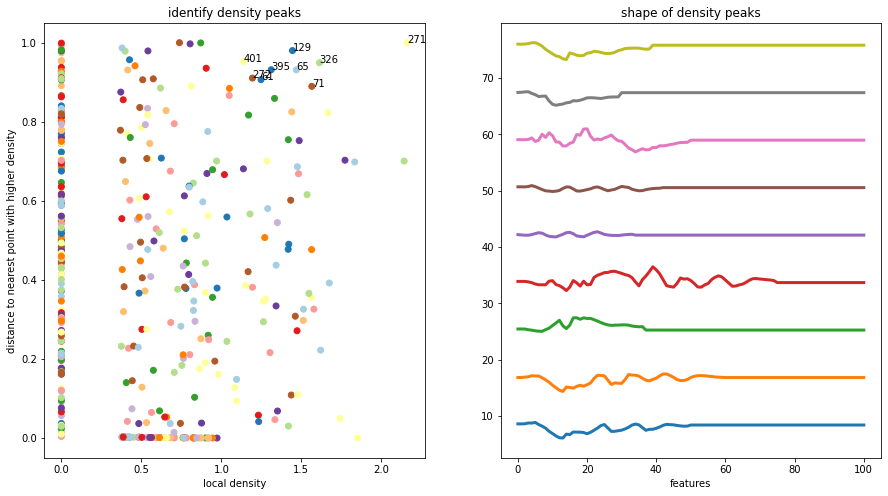

density peack clusters acquired


In [6]:
# step 2-1: select density peak

# this method focus on density peak of data, powerful for ununiform distribution
# reference: Clustering by Fast Search and Find of Density Peaks (2014 Science)

step2_data = tsne_data
large_data = False 
down_sample = 10000

if large_data:
    row_sequence= np.random.choice(step2_data.shape[0],down_sample,replace=False, p=None)
    step2_data = step2_data[row_sequence,:]

distance_matrix = pairwise_distances(step2_data, metric='cosine')
cut_distance = np.percentile(distance_matrix[distance_matrix!=0], 0.2) # if too many points have 0 density, increase it!
density = np.empty(step2_data.shape[0])
for idx,distance_vector in enumerate(distance_matrix.copy()):
    distance_vector[distance_vector>cut_distance] = 0
    density[idx] = np.sum(np.exp(-distance_vector[distance_vector!=0]/cut_distance))

higher_distance = np.zeros(step2_data.shape[0])
density_rank = density.argsort()

for i in range(step2_data.shape[0]-1):
    higher_distance[density_rank[i]] = distance_matrix[density_rank[i]][density_rank[i+1]]

higher_distance = higher_distance/np.max(higher_distance)
higher_distance[density_rank[-1]] = 1

density_ = density > np.percentile(density,85)   # threshold for density peak selection
higher_distance_ = higher_distance > np.percentile(higher_distance,90) # threshold for density peak selection
possible_center = np.where(density_ * higher_distance_ == True)[0]

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].scatter(density,higher_distance,c=np.random.rand(step2_data.shape[0]),cmap='Paired')
for idx in possible_center:
    ax[0].text(density[idx], higher_distance[idx], idx)

ax[0].set_title('identify density peaks')
ax[0].set_xlabel("local density")
ax[0].set_ylabel("distance to nearest point with higher density")

possible_center_ = np.empty((possible_center.shape[0],data.shape[1]))
for idx,i in enumerate(possible_center):
    possible_center_[idx] = data[i]
gap = 2*np.max(np.max(possible_center_,axis=1)-np.min(possible_center_,axis=1))
c = 0
for i in possible_center_:
    c = c+1
    ax[1].scatter(range(data.shape[1]),i+c*gap,s=3)
ax[1].set_xlabel('features')
ax[1].set_title('shape of density peaks')
plt.show()

# step 2-2: assign point to their nearest point with higher density
not_center = []
centers = set(possible_center) - set(not_center)
cluster_dp = -np.ones(step2_data.shape[0])
for idx, i in enumerate(centers):
    cluster_dp[i] = idx
density_rank = density_rank[::-1]
for idx in range(1,step2_data.shape[0]):
    if cluster_dp[density_rank[idx]] == -1:
        higher_point_list = density_rank[:idx]
        higher_point_distance = np.empty(higher_point_list.shape[0])
        for ii,i in enumerate(higher_point_list):
            higher_point_distance[ii] = distance_matrix[density_rank[idx]][i]
        cluster_dp[density_rank[idx]] = cluster_dp[higher_point_list[np.argmin(higher_point_distance)]]
print('density peack clusters acquired')

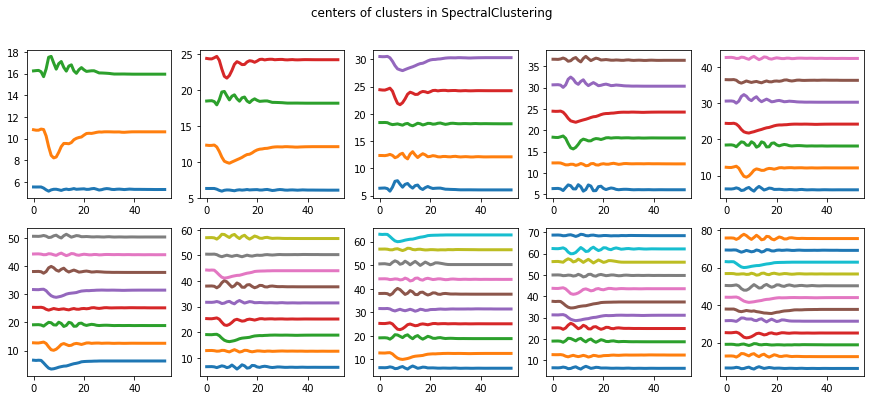

Spectral clusters acquired


In [7]:
# step 3: spectral clustering

# using nomarlized cut, available for uniform distribution



step3_data = dwt_data
large_data = False 
down_sample = 10000

if large_data:
    row_sequence= np.random.choice(step3_data.shape[0],down_sample,replace=False, p=None)
    step3_data = step3_data[row_sequence,:]

k_min = 3
k_max = 12
num_of_trail = k_max-k_min+1

fig, ax = plt.subplots(ceil(num_of_trail/5),5, figsize=(15, 3*ceil(num_of_trail/5)))
fig.suptitle('centers of clusters in SpectralClustering')
for idx,k,ax_ in zip(range(num_of_trail),range(k_min,k_max+1),ax.flat[:num_of_trail]):
    spectiral = SpectralClustering(n_clusters=k, random_state=0, n_neighbors=ceil(np.log2(step3_data.shape[0]))
                                   , affinity='nearest_neighbors').fit(step3_data)
    centers = np.empty((k,step3_data.shape[1]))
    for i in range(k):
        centers[i] = np.mean(step3_data[spectiral.labels_==i,:],axis=0)
    gap = 2*np.max(np.max(centers,axis=1)-np.min(centers,axis=1))
    c = 0
    for i in centers:
        c = c+1
        ax_.scatter(range(step3_data.shape[1]),i+c*gap,label=str(i),s=3)
plt.show()

# Finally, decide your number of clusters
number_of_cluster = 6
cluster_spectral = SpectralClustering(n_clusters=number_of_cluster, random_state=0, n_neighbors=ceil(np.log2(step3_data.shape[0]))
                                   , affinity='nearest_neighbors').fit(step3_data).labels_
print('Spectral clusters acquired')

Boolean clusters acquired


C:\Users\portugueslab\Anaconda3\lib\site-packages\matplotlib-3.3.3-py3.8-win-amd64.egg\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


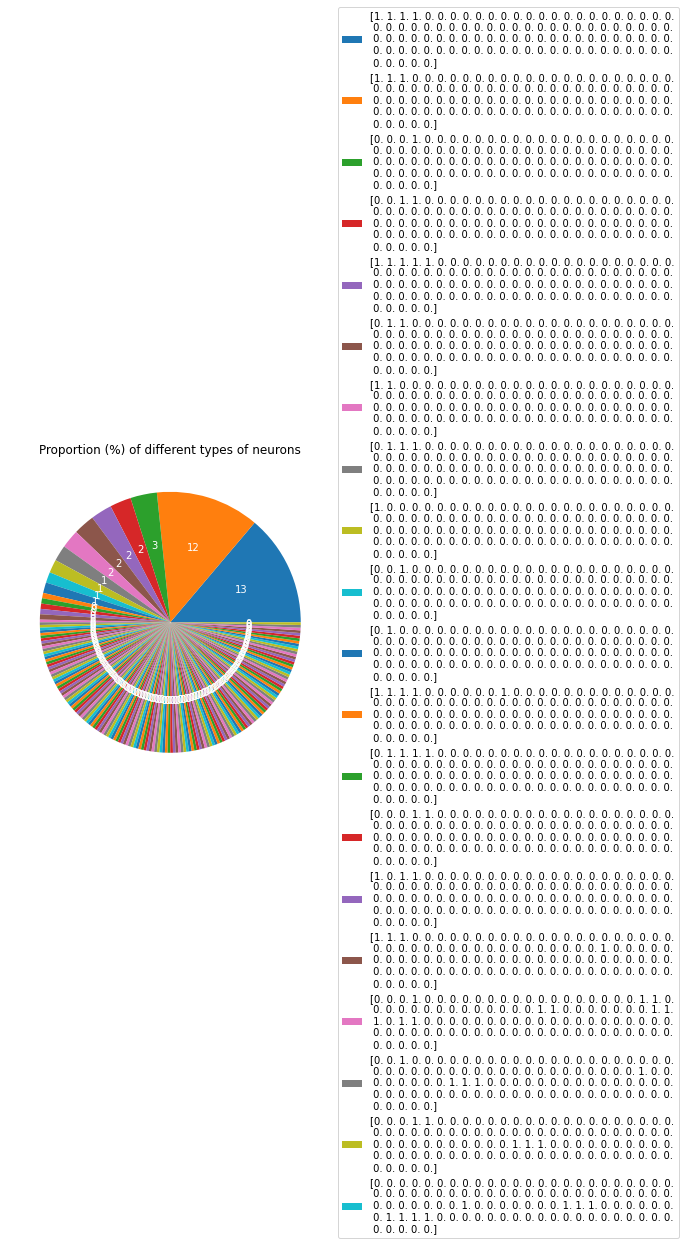

In [8]:
# step 4: specific method - fetures are average responses for different stimulus

# make features boolean value, i.e., feature will be 1 (have response) or 0 (no response)
step4_data = data.copy()

# get for Naumann et al, cell 2016
threshold = 1.8 * np.std(step4_data,axis=0)

step4_data -= threshold
step4_data[step4_data>=0] = 1
step4_data[step4_data<0] = 0

centers = np.unique(step4_data,axis=0)
cluster_boolean = np.empty(step4_data.shape[0])

for idx_data,ins_data in enumerate(step4_data):
    for idx_center,ins_center in enumerate(centers):
        if np.array_equal(ins_data,ins_center):
            cluster_boolean[idx_data] = idx_center
            break
print('Boolean clusters acquired')

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
fig_data = np.array([[np.sum(cluster_boolean==i),i] for i in range(centers.shape[0])])
fig_data = fig_data[fig_data[:,0].argsort()][::-1][1:] 
wedges, texts, autotexts = ax.pie(fig_data[:,0], textprops=dict(color="w"),autopct='%d')

ax.set_title('Proportion (%) of different types of neurons')
ax.legend(wedges, [centers[i] for i in fig_data[:,1]][:20],
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

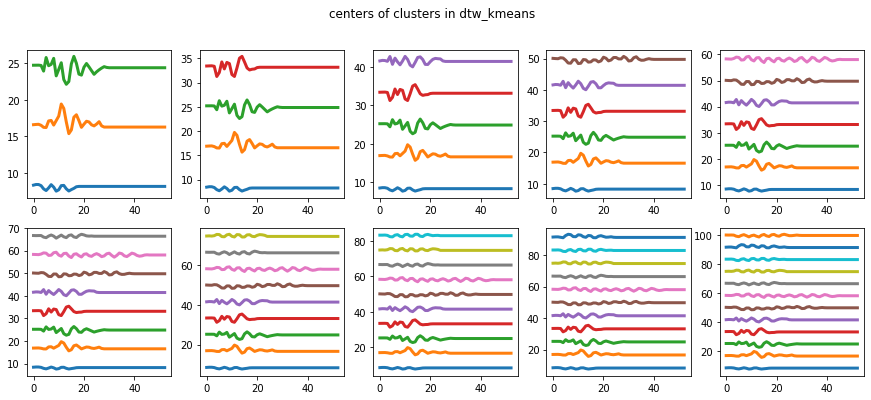

dtw_k-means clusters acquired


In [9]:
# step 5: specific method - fetures are time series

# using DTW(Dynamic Time Warping) rather than Euclidean Distance
# what is DTW: align time seires, e.g.: 2 persons say the same sentence
# DTW can align each word though they say with different speed

from dtaidistance import dtw,clustering

step5_data = dwt_data

k_min = 3
k_max = 12
num_of_trail = k_max-k_min+1

fig, ax = plt.subplots(ceil(num_of_trail/5),5, figsize=(15, 3*ceil(num_of_trail/5)))
fig.suptitle('centers of clusters in dtw_kmeans')
for idx,k,ax_ in zip(range(num_of_trail),range(k_min,k_max+1),ax.flat[:num_of_trail]):
    dtw_model = clustering.KMeans(k=k, max_it=20, max_dba_it=20,show_progress=False)
    dtw_kmeans,_ = dtw_model.fit(step5_data, use_c=True, use_parallel=False)
    centers = np.empty((k,step5_data.shape[1]))
    for idx,i in enumerate(dtw_kmeans.keys()):
        centers[idx] = step5_data[i]
    gap = 2*np.max(np.max(centers,axis=1)-np.min(centers,axis=1))
    c = 0
    for i in centers:
        c = c+1
        ax_.scatter(range(step5_data.shape[1]),i+c*gap,label=str(i),s=3)
plt.show()

# decide your number of clusters
number_of_cluster = 6
dtw_model = clustering.KMeans(k=number_of_cluster, max_it=20, max_dba_it=20,show_progress=False)
cluster_dtw_kmeans,_ = dtw_model.fit(step5_data, use_c=True, use_parallel=False)
print('dtw_k-means clusters acquired')

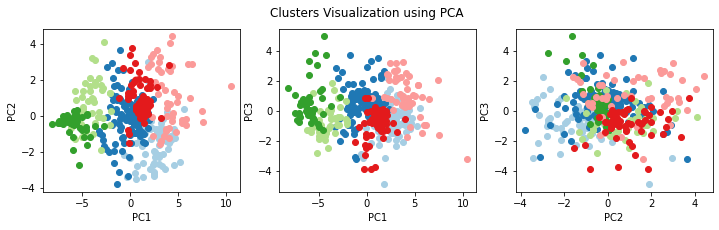

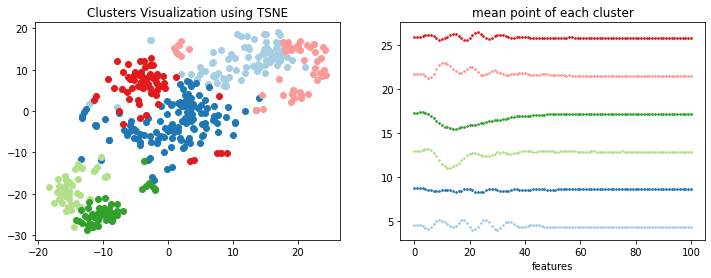

In [11]:
# step 6: Visualization of your clustering result

cluster_result = cluster_spectral

number_of_cluster = len(np.unique(cluster_result))
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('Clusters Visualization using PCA')
X_embedded = PCA(n_components=4).fit_transform(data)
idx_list=[(0,1),(0,2),(1,2)]
for idx,ax_ in zip(idx_list,ax.flat):
    ax_.set(xlabel='PC{}'.format(str(idx[0]+1)),ylabel='PC{}'.format(str(idx[1]+1)))
    for i in range(number_of_cluster):
        ax_.scatter(X_embedded[cluster_result==i][:,idx[0]],X_embedded[cluster_result==i][:,idx[1]], color=plt.cm.Paired(i%12))
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

X_embedded = TSNE(n_components=2).fit_transform(data)
for i in range(number_of_cluster):
    ax[0].scatter(X_embedded[cluster_result==i][:,0],X_embedded[cluster_result==i][:,1], color=plt.cm.Paired(i%12))
ax[0].set_title("Clusters Visualization using TSNE")

centers = np.empty((number_of_cluster,data.shape[1]))
for i in range(number_of_cluster):
    centers[i] = np.mean(data[cluster_result==i],axis=0)
gap = 2*np.max(np.max(centers,axis=1)-np.min(centers,axis=1))
c = 0
for idx,i in enumerate(centers):
    c = c+1
    ax[1].scatter(range(data.shape[1]),i+c*gap,label=str(i),s=3,color=plt.cm.Paired((c-1)%12))
ax[1].set_xlabel('features')
ax[1].set_title('mean point of each cluster')
plt.show()